In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
from scipy.ndimage import zoom

In [66]:
# Folder path containing binary files
folder_path = '/run/media/sachin/0fa21ddb-f70c-4238-9cf4-705e0360f1c1/Test/'
#folder_path = '/run/media/sachin/0fa21ddb-f70c-4238-9cf4-705e0360f1c1/NICT DUMP/idata2020/idata202009/'

In [ ]:
# Constants
max_long, max_lat = 321, 221 #maximum long and lat per the raw files
inter_long, inter_lat, hemisphere_lat = 90, 40, 59 #desired lon/mlt size, desired lat size, size of lat per hemisphere
fac_norm = 3.75e-6  # A/m^2 for FAC
pot_norm = 1.017e7  # V for potential
cond_norm = 15  # S/m for conductivity
chunk_size = 10000  # Number of files to process per chunk
dt_str = folder_path[-7:-1] #extract date from folder path
dt_str = '20200901'

# List all the files in the folder
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Function to process a chunk of files
def process_files_chunk(file_chunk, hemi, res):
    datasets = []
    for file_name in file_chunk:
        file_path = os.path.join(folder_path, file_name)

        # Extract datetime from filename (last 12 characters hold the datetime)
        dt_str = file_name[-12:]
        try:
            date_obj = pd.to_datetime(dt_str, format='%Y%m%d%H%M')
        except ValueError:
            print(f"Skipping file {file_name}, invalid date format")
            continue

        # Open and read binary file
        with open(file_path, 'rb') as f:
            _ = np.fromfile(f, dtype=np.int32, count=1)[0] #count
            _ = np.fromfile(f, dtype=np.float32, count=1)[0] #time
            _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long)) #vx
            _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long)) #vy
            _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long)) #vz
            pot = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
            fac = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
            sxx = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
            syy = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
            sxy = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))

            # Apply normalization and unit conversion
            pot = (pot * pot_norm) / 1e3  # convert V to kV
            fac = (fac * fac_norm) * 1e6  # convert A/m^2 to uA/m^2
            sxx = sxx * cond_norm
            syy = syy * cond_norm
            sxy = sxy * cond_norm

            #shift indices
            pot[0,0] = pot[2,0]
            pot[1,0] = pot[2,0]
            fac[0,0] = fac[2,0]
            fac[1,0] = fac[2,0]
            
            # Select hemisphere
            if hemi == 'NH':
                s_ind, e_ind = 161, 220
            else:
                s_ind, e_ind = 0, hemisphere_lat

            pot = pot[s_ind:e_ind, :]
            fac = fac[s_ind:e_ind, :]
            sxx = sxx[s_ind:e_ind, :]
            syy = syy[s_ind:e_ind, :]
            sxy = sxy[s_ind:e_ind, :]

            #interpolate to reduce size
            def interpolate(data):
                data = zoom(data, ((inter_lat/hemisphere_lat), (inter_long/max_long)), order=1)
                return data
            
            pot = interpolate(pot)
            fac = interpolate(fac)
            sxx = interpolate(sxx)
            syy = interpolate(syy)
            sxy = interpolate(sxy)

            
            # Create xarray Dataset
            ds = xr.Dataset(
                {
                    'pot': (['lat', 'lon'], pot),
                    'fac': (['lat', 'lon'], fac),
                    'sxx': (['lat', 'lon'], sxx),
                    'syy': (['lat', 'lon'], syy),
                    'sxy': (['lat', 'lon'], sxy),
                },
                coords={
                    'dt': date_obj,
                    'lat': np.arange(50, 90),
                    'lon': np.arange(1, 361, 4),
                }
            )

            # Append to list
            datasets.append(ds)

    # Concatenate all datasets in the list
    ds_full = xr.concat(datasets, dim='dt')
    ds_full = ds_full.resample(dt=f'{res}min').mean()
    ds_full = ds_full.interpolate_na(dim='dt')
    
    return ds_full

#settings 
feature_list = ['pot', 'fac', 'sxx', 'syy', 'sxy']
hemi = 'NH'  # Select hemisphere
combined_ds = None
resolution = 2 #set resolution

#we have to process the files in chunks as the files are too large to process at once
for i in range(0, len(file_list), chunk_size):
    # Select a chunk of files, but skip every other file (i.e., take files at 2-min resolution)
    file_chunk = file_list[i:i+chunk_size]
    
    # Process the chunk
    chunk_ds = process_files_chunk(file_chunk, hemi, resolution)

    if chunk_ds is not None:
        if combined_ds is None:
            combined_ds = chunk_ds  # Initialize combined dataset
        else:
            combined_ds = xr.concat([combined_ds, chunk_ds], dim='dt')


combined_ds.to_netcdf(f'/run/media/sachin/0fa21ddb-f70c-4238-9cf4-705e0360f1c1/NICT_Data/test/{dt_str}_{inter_long}_{inter_lat}_{resolution}min.nc')
combined_ds

In [67]:
# Constants
max_long, max_lat = 321, 221  # Maximum longitude and latitude per the raw files
inter_long, inter_lat, hemisphere_lat = 90, 40, 59  # Desired lon/mlt size, desired lat size, size of lat per hemisphere
fac_norm = 3.75e-6  # A/m^2 for FAC
pot_norm = 1.017e7  # V for potential
cond_norm = 15  # S/m for conductivity
chunk_size = 10000  # Number of files to process per chunk
#dt_str = '20200901'  # Hardcoded date extraction (as an example)

# List all the files in the folder
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Function to interpolate and normalize the data
def interpolate_and_normalize(data, norm_factor, scale_factor):
    data = (data * norm_factor) * scale_factor  # Apply normalization
    data = zoom(data, ((inter_lat/hemisphere_lat), (inter_long/max_long)), order=1)  # Interpolate
    return data

# Function to process a chunk of files for a specific feature
def process_files_chunk(file_chunk, hemi, res, feature):
    datasets = []
    for file_name in file_chunk:
        file_path = os.path.join(folder_path, file_name)

        # Extract datetime from filename (last 12 characters hold the datetime)
        dt_str = file_name[-12:]
        date_obj = pd.to_datetime(dt_str, format='%Y%m%d%H%M')

        # Open and read binary file
        with open(file_path, 'rb') as f:
            _ = np.fromfile(f, dtype=np.int32, count=1)[0]  # Count
            _ = np.fromfile(f, dtype=np.float32, count=1)[0]  # Time
            _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))  # vx
            _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))  # vy
            _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))  # vz
            pot = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
            fac = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
            sxx = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
            syy = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
            sxy = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))

            # Select hemisphere
            if hemi == 'NH':
                s_ind, e_ind = 161, 220
            else:
                s_ind, e_ind = 0, hemisphere_lat

            # Extract the feature data
            feature_data = {
                'pot': pot[s_ind:e_ind, :],
                'fac': fac[s_ind:e_ind, :],
                'sxx': sxx[s_ind:e_ind, :],
                'syy': syy[s_ind:e_ind, :],
                'sxy': sxy[s_ind:e_ind, :]
            }[feature]

            # Apply normalization and interpolation based on the feature
            if feature == 'pot':
                feature_data = interpolate_and_normalize(feature_data, pot_norm, scale_factor=1e-3)  # Convert V to kV
            elif feature == 'fac':
                feature_data = interpolate_and_normalize(feature_data, fac_norm, scale_factor=1e6) # Convert A/m^2 to uA/m^2
            else:
                feature_data = interpolate_and_normalize(feature_data, cond_norm, scale_factor=1) # No conversion for conductivity

            # Create xarray Dataset
            ds = xr.Dataset(
                {
                    feature: (['lat', 'lon'], feature_data)
                },
                coords={
                    'dt': date_obj,
                    'lat': np.linspace(50, 90, inter_lat),
                    'lon': np.arange(1, 361, 4),
                }
            )

            # Append to list
            datasets.append(ds)

    # Concatenate all datasets in the list
    ds_full = xr.concat(datasets, dim='dt')
    ds_full = ds_full.resample(dt=f'{res}min').mean()
    ds_full = ds_full.interpolate_na(dim='dt')

    return ds_full

# PARAMETERS
feature_list = ['pot', 'fac', 'sxx', 'syy', 'sxy']
hemi = 'NH'  # Select hemisphere
resolution = 2  # Set resolution

combined_features = []  # Initialize list to store combined datasets for each feature
for feature in feature_list:
    feature_ds = None  # Initialize combined dataset for each feature

    for i in range(0, len(file_list), chunk_size):

        file_chunk = file_list[i:i+chunk_size] # Select a chunk of files
        chunk_ds = process_files_chunk(file_chunk, hemi, resolution, feature) # Process the chunk

        # Concatenate datasets across chunks
        if feature_ds is None:
            feature_ds = chunk_ds
        else:
            feature_ds = xr.concat([feature_ds, chunk_ds], dim='dt')

    # Save the dataset to a NetCDF file
    feature_ds.to_netcdf(f'/run/media/sachin/0fa21ddb-f70c-4238-9cf4-705e0360f1c1/NICT_Data/test/{dt_str}_{feature}_{inter_long}_{inter_lat}_{resolution}min.nc')

    # Append to the list
    combined_features.append(feature_ds)

# Combine all features into a single dataset (for testing below, not for ML)
combined_ds = xr.merge(combined_features)
combined_ds

<xarray.Dataset> Size: 52MB
Dimensions:  (lat: 40, lon: 90, dt: 720)
Coordinates:
  * lat      (lat) float64 320B 50.0 51.03 52.05 53.08 ... 87.95 88.97 90.0
  * lon      (lon) int64 720B 1 5 9 13 17 21 25 ... 333 337 341 345 349 353 357
  * dt       (dt) datetime64[ns] 6kB 2020-08-01 ... 2020-08-01T23:58:00
Data variables:
    pot      (dt, lat, lon) float32 10MB 4.877 4.613 4.319 ... 2.135 2.126 2.116
    fac      (dt, lat, lon) float32 10MB 0.0 0.0 0.0 ... 0.007178 0.006339
    sxx      (dt, lat, lon) float32 10MB 1.871 1.871 1.871 ... 4.682 4.681 4.68
    syy      (dt, lat, lon) float32 10MB 1.506 1.506 1.506 ... 4.684 4.683 4.682
    sxy      (dt, lat, lon) float32 10MB 1.623 1.623 1.623 ... 4.684 4.682 4.681

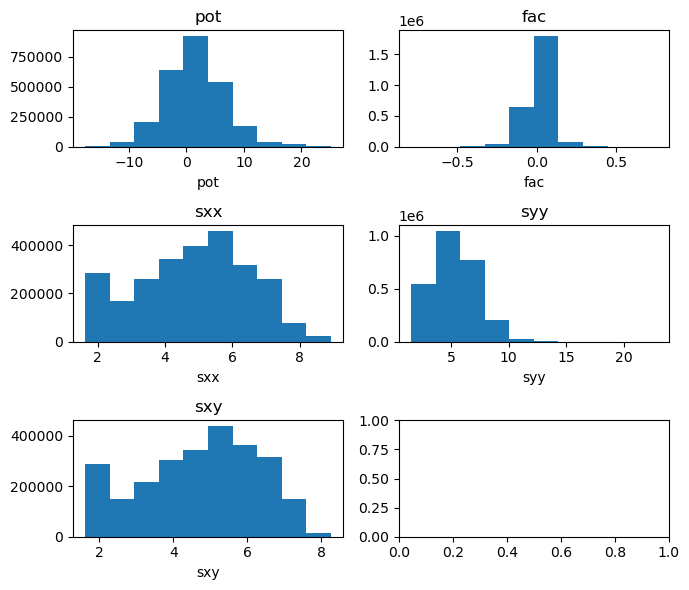

In [68]:
fig, ax = plt.subplots(3, 2, figsize=(7, 6))

for i, var in enumerate(['pot', 'fac', 'sxx', 'syy', 'sxy']):
    combined_ds[var].plot(ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(var)
    plt.tight_layout()

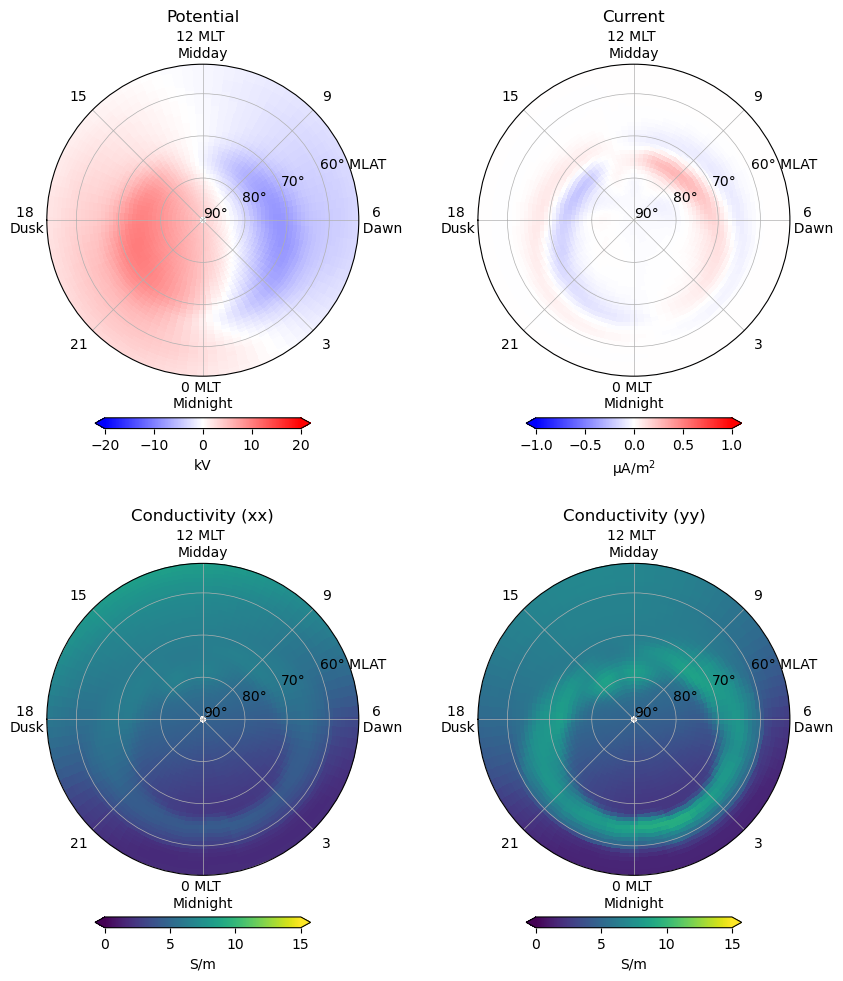

In [69]:

# Define common parameters
theta = np.deg2rad(np.linspace(0, 360, inter_long) - 90)
r = 90 - np.linspace(53.1, 89.7, inter_lat)
shrink = 0.4
fig, ax = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(10, 10))

#potential
mesh1 = ax[0, 0].pcolormesh(theta, r, combined_ds['pot'].mean('dt'), shading='auto', cmap='bwr', vmin=-20, vmax=20)
ax[0, 0].set_title('Potential')
fig.colorbar(mesh1, ax=ax[0, 0], label='kV', orientation='horizontal', pad=0.1, shrink=shrink, extend='both')

#current
mesh2 = ax[0, 1].pcolormesh(theta, r, combined_ds['fac'].mean('dt'), shading='auto', cmap='bwr', vmin = -1, vmax = 1)
ax[0, 1].set_title('Current')
fig.colorbar(mesh2, ax=ax[0, 1], label=r'$\mathrm{\mu}$A/m$^2$', orientation='horizontal', pad=0.1, shrink=shrink, extend='both')

#sxx
mesh3 = ax[1, 0].pcolormesh(theta, r, combined_ds['sxx'].mean('dt'), shading='auto', cmap='viridis', vmin=0, vmax=15)
ax[1, 0].set_title('Conductivity (xx)')
fig.colorbar(mesh3, ax=ax[1, 0], label='S/m', orientation='horizontal', pad=0.1, shrink=shrink, extend='both')

#syy
if hemi == 'NH':
    mesh4 = ax[1, 1].pcolormesh(theta, r, combined_ds['syy'].mean('dt'), shading='auto', cmap='viridis', vmin=0, vmax=15)
else:
    mesh4 = ax[1, 1].pcolormesh(theta, r, combined_ds['syy'].mean('dt'), shading='auto', cmap='viridis_r', vmin=-15, vmax=0)
ax[1, 1].set_title('Conductivity (yy)')
fig.colorbar(mesh4, ax=ax[1, 1], label='S/m', orientation='horizontal', pad=0.1, shrink=shrink, extend='both')

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylim([0, 37])
        ax[i,j].set_yticks([0, 10, 20, 30])
        ax[i,j].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
        ax[i,j].set_xlim([-np.pi, np.pi])
        ax[i,j].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
        ax[i,j].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
        ax[i,j].grid(True, linestyle='-', linewidth=0.5, zorder=6)

plt.tight_layout()
#space between subplots
plt.subplots_adjust(wspace=-0.2, hspace=0.2)
